In [8]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import cross_decomposition

%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
%run ./skills.py # contains subsetSkills, createCountryPenRates
%run ./fileWork.py # contains complIndexClean
%run ./plsMain # contains pls (need boxCox) 
%run ./boxCox.py 

In [10]:
# Set variables for rest of exercise
baseFile = '../00_originalData/li_country_industry_det_skill_2016.tsv'
skillName = 'std_skill_name'
threshold = 0.001
#li = pd.read_csv(basefile, sep='\t')
skillPen = readLimitMergeSkills(baseFile=baseFile,
                                skillName=skillName,
                                threshold=threshold)

Original file

   country_sk  industry_sk  skill_id             std_skill_name  hire_ct  \
0         239           96      1101            public speaking        3   
1         239           -9      1164       instructional design        3   
2         239           57      1004                 completion        3   
3         239           -9       344  administrative assistance        5   
4         239           -9      3526              water quality        0   

   skill_member_ct  member_ct  penetration_rate  hiring_rate  
0               34        192           0.17708      0.08824  
1               64      10731           0.00596      0.04688  
2              117        746           0.15684      0.02564  
3               79      10731           0.00736      0.06329  
4               35      10731           0.00326      0.00000  

Number of individual skills without censoring (beyond LI's rule of 30)
(32835,)

Skill with minimum number of global members given threshold:
penRate

In [12]:
subsetSkills = pd.read_csv('../02_data/subsetSkillKnowledge.csv')
skillPen = skillPen[subsetSkills['std_skill_name']]

In [13]:
gdppcPPP = pd.read_csv('../00_originalData/API_NY.GDP.PCAP.PP.CD_DS2_en_csv_v2.csv', skiprows=4)
gdppcPPP = gdppcPPP[['Country Name', 'Country Code', '2016']].dropna()
gdppcPPP.rename(columns={'2016':'gdppcppp2016'}, inplace=True)

empl = pd.read_csv('../00_originalData/API_SL.EMP.TOTL.SP.ZS_DS2_en_csv_v2.csv', skiprows=4)
empl = empl[['Country Name', 'Country Code', '2016']].dropna()
empl.rename(columns={'2016':'empl2016'}, inplace=True)

outcomes = pd.merge(gdppcPPP.drop('Country Name', axis=1),
                    empl.drop('Country Name', axis=1),
                    on='Country Code', how='inner')
outcomes.rename(columns={'Country Code' : 'iso3'}, inplace=True)
outcomes.head()

,iso3,gdppcppp2016,empl2016
0,AFG,1944.117005,48.000000
1,AGO,6454.135370,64.500000
2,ALB,11540.025561,43.400002
3,ARB,16726.722185,44.347946
4,ARE,72399.653473,77.699997


In [14]:
# The following reads and cleans the Compl Index data and merges ECI to skill pen rates
penRatesOutcome = skillPenToOutcome(skillPen=skillPen,
                            outcome=outcomes,
                            outcomeFields=['gdppcppp2016', 'empl2016'])

In [15]:
penRatesOutcome.shape
penRatesOutcome.columns
penRatesOutcome.head()

(131, 589)

Index(['country', '.net framework', '2g', '3g', 'abap', 'accounting',
       'active directory', 'active server pages (asp)', 'administrative law',
       'adobe acrobat',
       ...
       'windows xp', 'wireless networking', 'wireless technologies',
       'wordpress', 'workers compensation', 'working with brokers', 'xhtml',
       'xml', 'gdppcppp2016', 'empl2016'],
      dtype='object', length=589)

,country,.net framework,2g,3g,abap,accounting,active directory,active server pages (asp),administrative law,adobe acrobat,...,windows xp,wireless networking,wireless technologies,wordpress,workers compensation,working with brokers,xhtml,xml,gdppcppp2016,empl2016
country_sk,,,,,,,,,,,,,,,,,,,,,
3,Afghanistan,0.002344,0.009477,0.015462,0.000000,0.075116,0.025787,0.000000,0.002045,0.000000,...,0.004140,0.005935,0.021896,0.003242,0.000000,0.000000,0.000000,0.005237,1944.117005,48.000000
6,Albania,0.009084,0.006534,0.010837,0.000000,0.101873,0.018645,0.000000,0.016972,0.001514,...,0.004064,0.005378,0.015817,0.016693,0.000000,0.000000,0.001514,0.015896,11540.025561,43.400002
62,Algeria,0.002045,0.011743,0.016935,0.001852,0.036278,0.008917,0.000000,0.001017,0.000707,...,0.001584,0.001830,0.018219,0.003993,0.000000,0.000000,0.000632,0.006391,15013.296380,38.799999
9,Angola,0.003318,0.002179,0.004525,0.000000,0.068311,0.017162,0.000000,0.002078,0.000000,...,0.002682,0.002346,0.011128,0.001575,0.000000,0.000000,0.000000,0.003352,6454.135370,64.500000
11,Argentina,0.018538,0.000967,0.003494,0.004616,0.049919,0.011497,0.003591,0.007140,0.002977,...,0.004957,0.002538,0.013560,0.013611,0.000273,0.001732,0.002027,0.019792,19939.930775,55.599998


In [16]:
temp=penRatesOutcome.drop(['country', 'gdppcppp2016', 'empl2016'], axis=1).apply(stats.skewtest)
print('Ditstibution of p values for skewness test of penetration rate regressors')
pd.Series([i[1] for i in temp]).describe()

print('\n\nSkewness for GDP PC PPP 2016')
stats.skewtest(penRatesOutcome['gdppcppp2016'])
print('\n\nDistribution of values for GDP PC PPP 2016')
penRatesOutcome['gdppcppp2016'].describe()

print('\n\nSkewness for Empl 2016')
stats.skewtest(penRatesOutcome['empl2016'])
print('\n\nDistribution of values for Empl 2016')
penRatesOutcome['empl2016'].describe()

Ditstibution of p values for skewness test of penetration rate regressors


count    5.860000e+02
mean     1.975006e-03
std      2.613402e-02
min      7.578362e-44
25%      1.323054e-19
50%      7.776964e-13
75%      1.039505e-08
max      5.675955e-01
dtype: float64



Skewness for GDP PC PPP 2016


SkewtestResult(statistic=6.2592437157792959, pvalue=3.8684890545928929e-10)



Distribution of values for GDP PC PPP 2016


count       131.000000
mean      22735.579761
std       22036.252757
min        1168.825626
25%        6374.862978
50%       15204.932464
75%       32788.895506
max      127480.482511
Name: gdppcppp2016, dtype: float64



Skewness for Empl 2016


SkewtestResult(statistic=0.77646394723764234, pvalue=0.4374751000092123)



Distribution of values for Empl 2016


count    131.000000
mean      57.973282
std       11.602446
min       32.099998
25%       51.300001
50%       58.400002
75%       63.650000
max       84.599998
Name: empl2016, dtype: float64

In [17]:
X = penRatesOutcome.drop(['country', 'gdppcppp2016', 'empl2016'], axis=1)
y = penRatesOutcome['gdppcppp2016'] # 'empl2016'
estimator = pls(X=X, y=y)

In [18]:
estimator.best_estimator_


Pipeline(memory=None,
     steps=[('linear', PLSRegression(copy=True, max_iter=500, n_components=3, scale=True, tol=1e-06))])

In [19]:
reg = cross_decomposition.PLSRegression(n_components=estimator.best_estimator_.steps[0][1].n_components)

In [20]:
fitted = reg.fit(X, y)

In [21]:
fitted.score(X, y)

0.71256886234448724

In [22]:
fitted.x_rotations_.shape
fitted.x_rotations_[:10]
pd.DataFrame(fitted.x_rotations_).describe()
fitted.y_rotations_

fitted.x_scores_.shape
pd.DataFrame(fitted.x_scores_).describe()
fitted.y_scores_.shape
pd.DataFrame(fitted.y_scores_).describe()

(586, 3)

array([[ 0.02111602,  0.05572863, -0.03482619],
       [-0.02415148,  0.04098937,  0.04242216],
       [-0.02170611,  0.04978887,  0.05240373],
       [ 0.03646347,  0.00112152, -0.02957362],
       [ 0.02403893, -0.01618785,  0.07049875],
       [ 0.04446899,  0.00247361, -0.01563768],
       [ 0.03478274,  0.01764435, -0.01739564],
       [ 0.00731517,  0.00573504,  0.00424549],
       [ 0.05243931, -0.02194253, -0.05471126],
       [ 0.05692006, -0.0116615 ,  0.0047434 ]])

,0,1,2
count,586.000000,586.000000,586.000000
mean,0.036193,0.005463,0.002785
std,0.019930,0.042367,0.047377
min,-0.024151,-0.103567,-0.131374
25%,0.021164,-0.021898,-0.031519
50%,0.038566,0.007379,0.002543
75%,0.052351,0.034060,0.032757
max,0.080890,0.110550,0.158810


array([ 1.])

(131, 3)

,0,1,2
count,1.310000e+02,1.310000e+02,1.310000e+02
mean,-6.169789e-16,2.000096e-16,-4.067993e-17
std,1.335299e+01,6.425567e+00,5.000467e+00
min,-1.752429e+01,-3.277035e+01,-1.144791e+01
25%,-9.952126e+00,-2.540095e+00,-3.245549e+00
50%,-2.842595e+00,-9.124246e-01,-4.311434e-01
75%,6.230739e+00,2.158675e+00,2.459541e+00
max,4.285610e+01,2.727503e+01,1.747859e+01


(131, 3)

,0,1,2
count,1.310000e+02,1.310000e+02,1.310000e+02
mean,8.135986e-16,-6.644388e-16,-8.542785e-16
std,1.894849e+01,1.197991e+01,1.122591e+01
min,-1.854478e+01,-8.058760e+01,-8.251929e+01
25%,-1.406822e+01,-3.918843e+00,-4.418499e+00
50%,-6.475439e+00,1.552608e+00,2.016339e+00
75%,8.644626e+00,5.212399e+00,5.024746e+00
max,9.006785e+01,2.818553e+01,2.418429e+01


In [23]:
temp = pd.Series(np.absolute(fitted.y_loadings_[0])).sort_values(ascending=False)

pc = pd.DataFrame(fitted.x_rotations_.T,  columns = penRatesOutcome.drop(
    ['country', 'gdppcppp2016', 'empl2016'], axis=1).columns)
pc.index.names = ['yLoads']
pc.index = fitted.y_loadings_[0]
pc

,.net framework,2g,3g,abap,accounting,active directory,active server pages (asp),administrative law,adobe acrobat,adobe creative suite,...,windows communication foundation (wcf),windows server,windows xp,wireless networking,wireless technologies,wordpress,workers compensation,working with brokers,xhtml,xml
0.052775,0.021116,-0.024151,-0.021706,0.036463,0.024039,0.044469,0.034783,0.007315,0.052439,0.056920,...,0.018323,0.037571,0.030598,0.009992,0.018166,0.017528,0.024224,0.054993,0.012281,0.017289
-0.059225,0.055729,0.040989,0.049789,0.001122,-0.016188,0.002474,0.017644,0.005735,-0.021943,-0.011661,...,0.066036,0.006960,0.018730,0.032156,0.035425,0.060897,0.012786,-0.014042,0.070641,0.058925
-0.053342,-0.034826,0.042422,0.052404,-0.029574,0.070499,-0.015638,-0.017396,0.004245,-0.054711,0.004743,...,-0.021163,-0.013295,0.032723,0.006312,0.012042,0.010684,0.029009,0.039815,0.025831,-0.031206


,0
database administration,-0.012867
network administration,-0.010765
data structures,-0.009516
bookkeeping,-0.009498
windows,-0.009345
online research,-0.009338
html,-0.009303
tax preparation,-0.008797
content development,-0.008374
feature writing,-0.008336


,0
data center,0.015088
restructuring,0.013168
storage area network (san),0.012913
infrastructure,0.012845
consolidation,0.012830
anti money laundering,0.012756
architecture,0.012650
documentation,0.012561
asset management,0.012271
enterprise risk management,0.012179


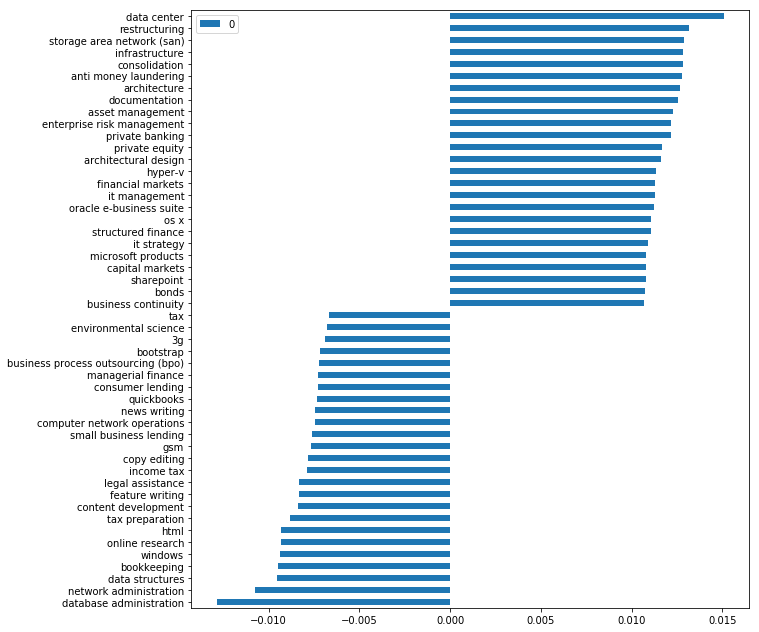

In [24]:
skillEffects = pd.Series(fitted.y_loadings_[0].dot(pc), index=pc.columns)

temp = pd.DataFrame(skillEffects).sort_values(by=0)
bins = np.arange(np.min(temp[0]), np.max(temp[0]) + 0.001, 0.001)
temp.head(25)
temp.tail(25).sort_values(by=0, ascending=False)

temp.head(25).append(temp.tail(25)).sort_values(by=0, ascending=True).plot(kind='barh', figsize=(10,11))

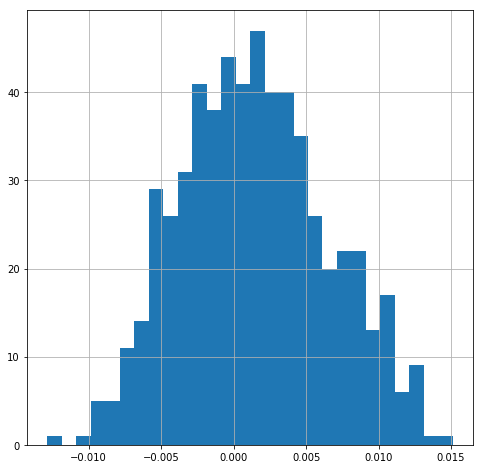

In [25]:
skillEffects.hist(bins=bins, figsize=(8,8))

Project management & business!
CPM scheduling = Complex Process Management
Project estimation
Value engineering
Project control
Document management
Primavera P6
Cost control

Construction:
Quantity surveying
Env, health, and safety
HVAC
Construction management
Construction
Fire safety
Bridge
Subcontracting
Building information modeling (bim)

Air:
airlines
commercial aviation
airports

Engineering:
microstation (3d cad software)

EPC could be construction or project management!
https://en.wikipedia.org/wiki/EPC#Business,_science_and_technology

Neg on gdp pc:
Old cell tech (gsm, 2g, 3g), oil drilling, data entry and web publishing like?

right_only    34334
both            586
left_only         0
Name: _merge, dtype: int64

,skillEffect,skill_name,parent_skill_name,_merge


,skillEffect
parent_skill_name,
software_development,-0.130372
writing,-0.052372
technical_support,-0.023499
telecommunications,-0.017840
data_management,-0.017332
web_design,-0.016795
environmental_science,-0.006773
customer_service,-0.006520
real_estate,-0.005815


,skillEffect
parent_skill_name,
finance,0.280773
information_technology,0.162087
system_administration,0.105532
business_strategy,0.094163
architecture,0.083059
sales,0.047701
insurance,0.034976
graphic_design,0.034416
computer_security,0.022827


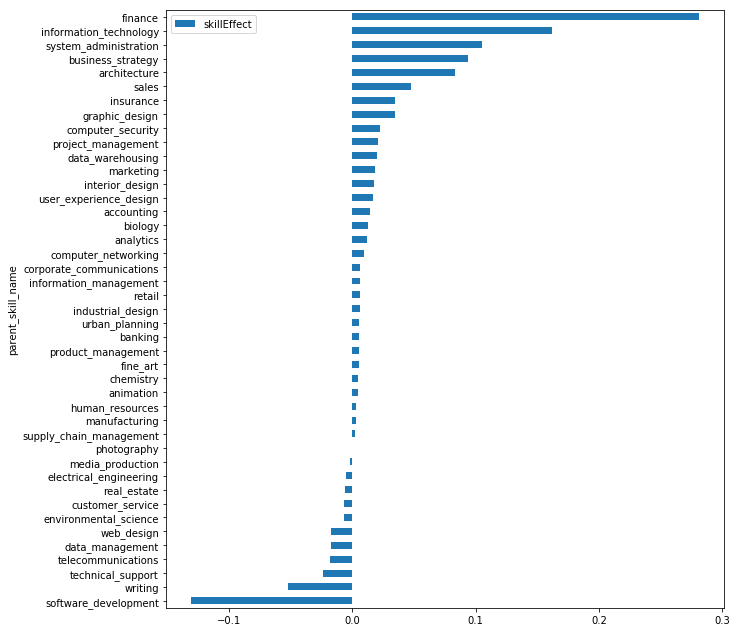

In [29]:
skillMaps = pd.read_csv('../00_originalData/li_parent_skill_map.tsv', sep='\t')[
             ['skill_name', 'parent_skill_name']]
skillMaps['skill_name'] = skillMaps['skill_name'].str.replace('_', ' ')

merged = pd.merge(pd.DataFrame(skillEffects, columns=['skillEffect']),
        skillMaps, left_index=True, right_on='skill_name',
        how='outer', indicator=True)
merged._merge.value_counts()
merged[merged._merge == 'left_only'].head() # orthopedic surgery, critical care nursing

parentSkillEffect = merged[['skillEffect', 'parent_skill_name']].groupby(
    by='parent_skill_name').sum()

parentSkillEffect = parentSkillEffect.sort_values(by=['skillEffect'])
parentSkillEffect[parentSkillEffect['skillEffect'] < 0]
parentSkillEffect[parentSkillEffect['skillEffect'] > 0].sort_values(by='skillEffect', ascending=False)

parentSkillEffect[parentSkillEffect['skillEffect'] < 0].append(
    parentSkillEffect[parentSkillEffect['skillEffect'] > 0]).plot(kind='barh', figsize=(10,11))

<Container object of 1582 artists>

Text(0.5,1,'Vector 1 (coef: 0.05992517484999305)')

<Container object of 1582 artists>

Text(0.5,1,'Vector 0 (coef: 0.03448804300974614)')

<Container object of 1582 artists>

Text(0.5,1,'Vector 2 (coef: 0.030773049453155725)')

<Container object of 1582 artists>

Text(0.5,1,'Vector 4 (coef: 0.030357298308546273)')

<Container object of 1582 artists>

Text(0.5,1,'Vector 3 (coef: 0.028190030731607377)')

<Container object of 1582 artists>

Text(0.5,1,'Vector 5 (coef: -0.023203549636067845)')

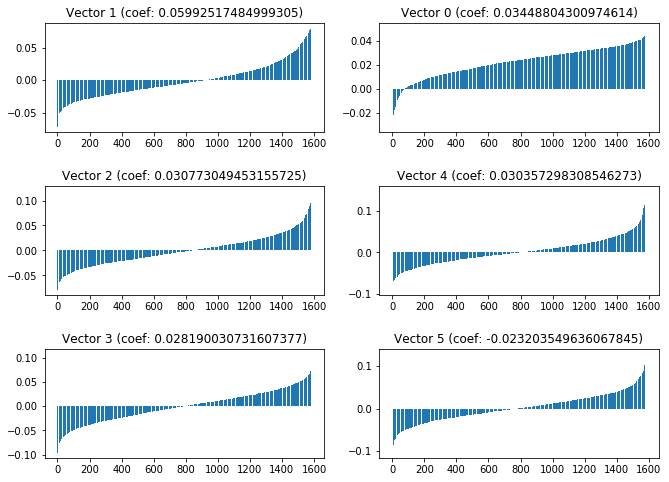

In [228]:
plt.figure(figsize=(11,8))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
for position in np.arange(0, estimator.best_estimator_.steps[0][1].n_components):
    component = temp.index[position]
    plt.subplot(3,2, position + 1)
    plt.bar(np.arange(0, pc.iloc[component].shape[0]), pc.iloc[component].sort_values())
    plt.title('Vector {} (coef: {})'.format(component, pc.index[component]))

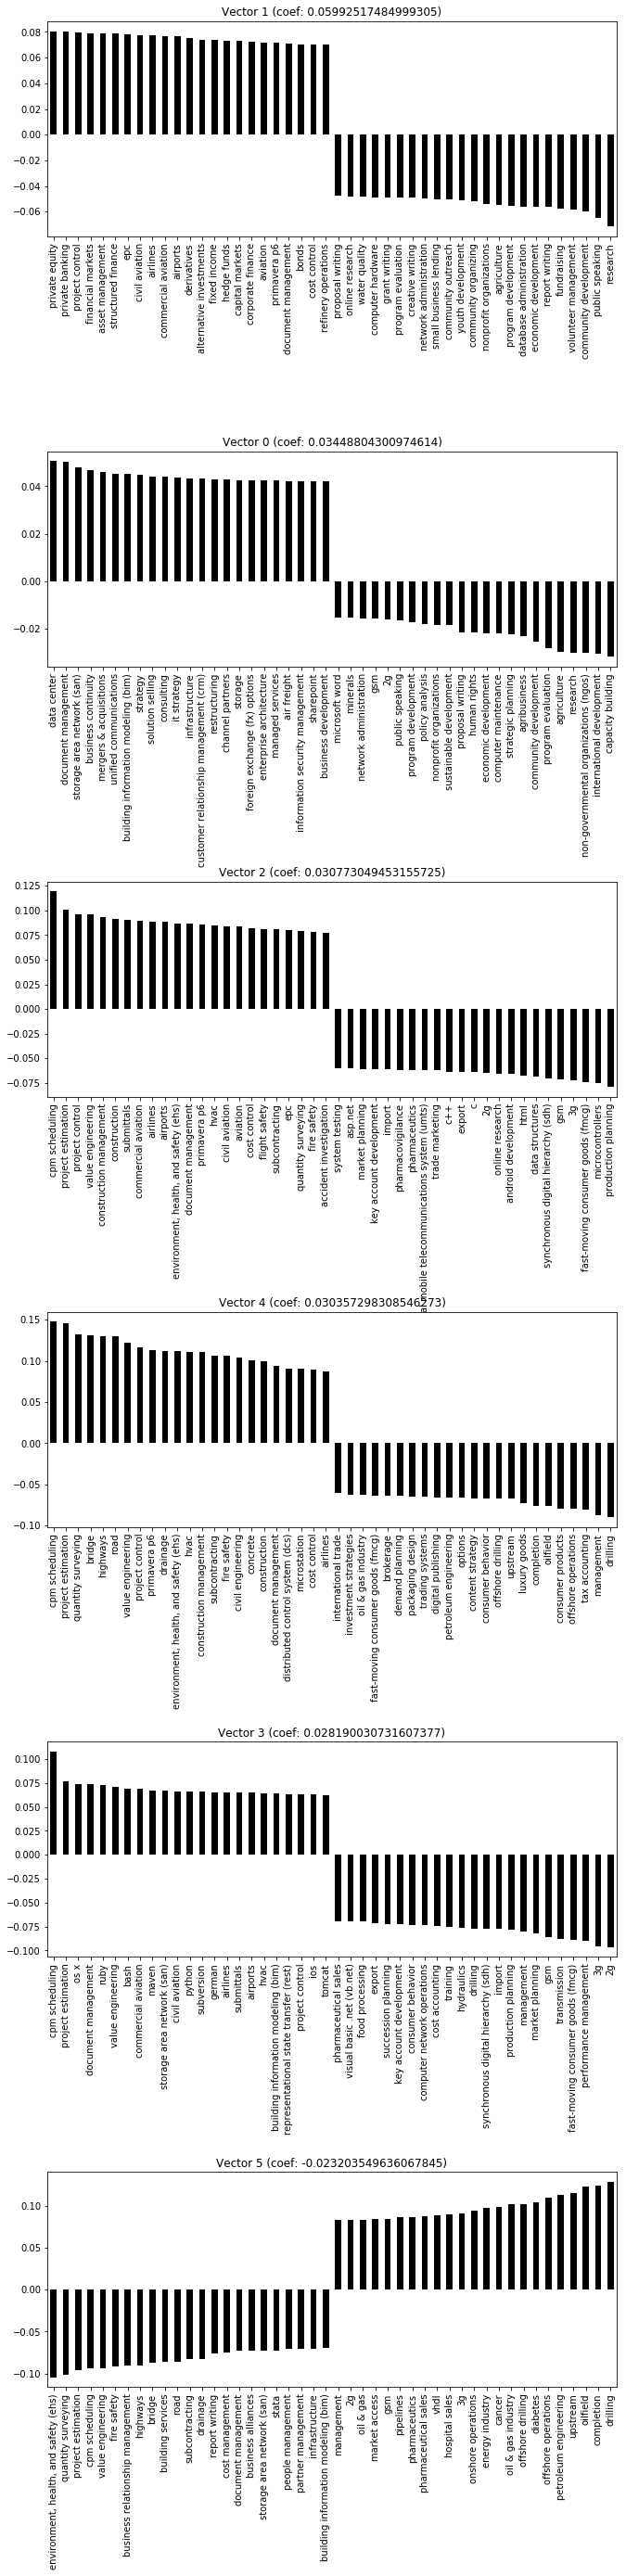

In [230]:
plt.figure(figsize=(11, 64))
plt.subplots_adjust(wspace=0.2, hspace=1.0)

components = pc.iloc[temp[0:estimator.best_estimator_.steps[0][1].n_components].index]
for i in np.arange(0, components.shape[0]):
    if pc.index[temp.index[i]] < 0:
        ascend = True
    else:
        ascend = False
    component = components.iloc[i].sort_values(ascending=ascend)
    component = component.iloc[0:23].append(component.iloc[-23:])
    plt.subplot(8,1, i + 1)
    component.plot.bar(colormap='gist_gray', 
                       title='Vector {} (coef: {})'.format(temp.index[i], pc.index[temp.index[i]]))
